# Seminar 4. Unsupervised learning
## Plan
* Hebbian and STDP network's weights dynamics
* How to choose hyperparameters


In [2]:
!pip install brian2
!pip install --upgrade numpy
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 31.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 23.9 MB/s 
     |████████████████████████████████| 944 kB 49.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import brian2 as b2
import numpy as np
import random

## 1. Create network

In [2]:
def plot_v_spikes(v_mon, s_mon, t_bounds=None, names=None):
    b2.figure(figsize=(12,4))

    b2.subplot(121)
    for i in range(len(v_mon.v)):
        if names:
            b2.plot(v_mon.t/b2.ms, v_mon.v[i], label=names[i])
        else:
            b2.plot(v_mon.t/b2.ms, v_mon.v[i], label=f'N_{i}')
    if t_bounds:
        b2.xlim(t_bounds)
    b2.xlabel('Time (ms)')
    b2.ylabel('v')
    b2.legend()

    b2.subplot(122)
    b2.plot(s_mon.t/b2.ms,s_mon.i, '.k')
    if t_bounds:
        b2.xlim(t_bounds)
    b2.xlabel('Time (ms)')
    b2.ylabel('Neuron num') 

Text(0.5, 0, 'Time (ms)')

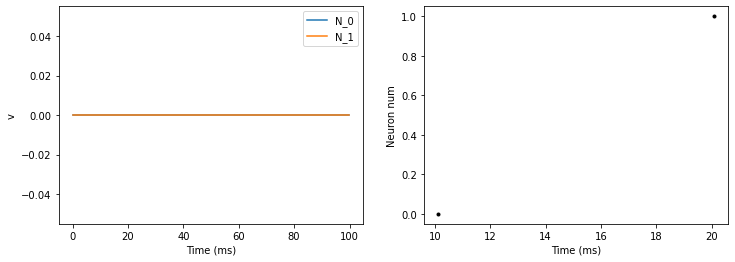

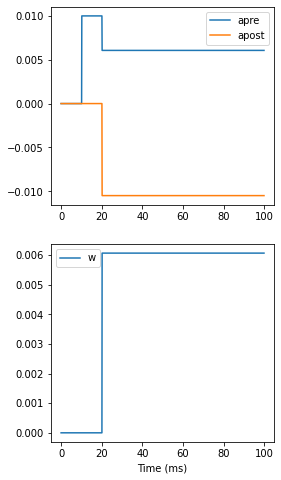

In [4]:
b2.start_scope()


taupre = taupost = 20*b2.ms
wmax = 0.01
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05

G = b2.NeuronGroup(2, 'v:1', threshold='t>(1+i)*10*ms', refractory=100*b2.ms)

S = b2.Synapses(G, G,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (event-driven)
             dapost/dt = -apost/taupost : 1 (event-driven)
             ''',
             on_pre='''
             v_post += w
             apre += Apre
             w = clip(w+apost, 0, wmax)
             ''',
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''')

S.connect(i=0, j=1)

v_mon = b2.StateMonitor(G, ['v'], record=True)
s_mon = b2.SpikeMonitor(G)
synapse_mon = b2.StateMonitor(S, ['w', 'apre', 'apost'], record=True)

b2.run(100*b2.ms)

plot_v_spikes(v_mon, s_mon)

b2.figure(figsize=(4, 8))
b2.subplot(211)
b2.plot(synapse_mon.t/b2.ms, synapse_mon.apre[0], label='apre')
b2.plot(synapse_mon.t/b2.ms, synapse_mon.apost[0], label='apost')
b2.legend()
b2.subplot(212)
b2.plot(synapse_mon.t/b2.ms, synapse_mon.w[0], label='w')
b2.legend(loc='best')
b2.xlabel('Time (ms)')

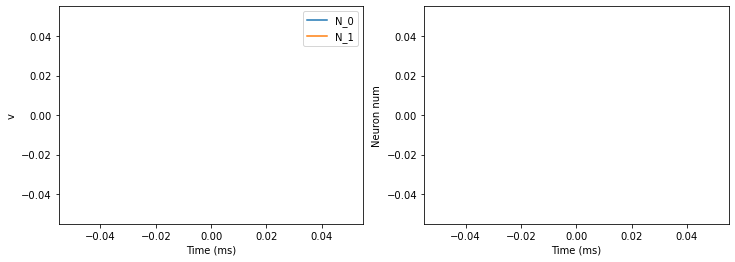

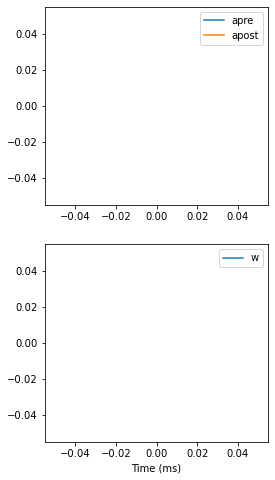

In [ ]:
b2.start_scope()

v_th = 0.95
eqs ='''
dv/dt=(v_th-v)/tau : 1
tau : second
'''

taupre = taupost = 20*b2.ms
wmax = 0.01
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05

G = b2.NeuronGroup(2, eqs, threshold='v>1', refractory=100*b2.ms)
G.tau = [10*b2.ms, 20*b2.ms]

PG = b2.PoissonGroup(2, 100 * b2.Hz)
w_syn = 3 * b2.mV
S_I = b2.Synapses(PG, G, on_pre='v += w_syn')
S_I.connect(i=[0,0],j=[1,1])


S = b2.Synapses(G, G,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (event-driven)
             dapost/dt = -apost/taupost : 1 (event-driven)
             ''',
             on_pre='''
             v_post += w
             apre += Apre
             w = clip(w+apost, 0, wmax)
             ''',
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''')

S.connect(i=0, j=1)
M = b2.StateMonitor(S, ['w', 'apre', 'apost'], record=True)
v_mon = b2.StateMonitor(G, 'v', record=True)
s_mon = b2.SpikeMonitor(G, record=True)


plot_v_spikes(v_mon, s_mon, t_bounds=None, names=None)


b2.figure(figsize=(4, 8))
b2.subplot(211)
b2.plot(M.t/b2.ms, M.apre[0], label='apre')
b2.plot(M.t/b2.ms, M.apost[0], label='apost')
b2.legend()
b2.subplot(212)
b2.plot(M.t/b2.ms, M.w[0], label='w')
b2.legend(loc='best')
b2.xlabel('Time (ms)');